## 0. Import modules and run an example of dummy_gym

In [ ]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym,EXPLORED,save_to_gif
import pickle
import time

# if there is a GPU available, set train the device to GPU
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Only I need to do this because I am running the code on my local machine
# os.chdir('/home/zhihan/ME5418')

# Create the environment instance
env = DummyGym()


2024-11-21 14:36:03.143641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:36:03.772492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-11-21 14:36:03.772571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

## 1. Parameters setting
In order to test our model, we did not assign large parameters. Set the training mode using one of the following options:
### Training Mode Options
- **`train`**: Start training from scratch, overwriting existing model, state, and replay buffer files.
- **`test`**: Test the model without overwriting any files.
- **`train_from_breakpoint`**: Continue training from the last saved breakpoint.
- **`fine_tune`**: Fine-tune the model while preserving the previous model.

In [2]:
# 断点文件会保存在train_breakpoint文件夹中
# 如果中途训练中断，可以从断点处继续训练，只需将train_mode设置为'train_from_breakpoint'，包括模型文件、状态文件和replay_buffer文件
# 如果想重新训练，将train_mode设置为'train'即可，模型文件、状态文件和replay_buffer文件会被覆盖
# 如果想测试模型，将train_mode设置为'test'即可，模型文件、状态文件和replay_buffer文件不会被覆盖
# 如果既想重新训练，又想保留之前的模型，即微调模型，将train_mode设置为'fine_tune'即可

train_mode = 'test'
# train_mode = 'train' # 'train' or 'test' or 'train_from_breakpoint' or 'fine_tune'
model_name = 'dqn_model.h5'
state_name = 'state.npz'
replay_buffer_name = 'replay_buffer.pkl'

breakpoint_path = 'train_breakpoint'
model_path = os.path.join(breakpoint_path, model_name)
state_path = os.path.join(breakpoint_path, state_name)
replay_buffer_path = os.path.join(breakpoint_path, replay_buffer_name)

# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 32 # 每次训练的数据量
n_episodes = 5 # 地图数量
time_steps = 1000 # 每张地图最多走多少步，避免陷入局部重复导致训练无效数据
epochs = 10 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate, 0.99 means the future rewards are considered important
epsilon = 0.8 # 探索率
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((1, *map.shape, 1))` to reshape the state to 4 dimensions

In [3]:
# 处理原始state
def prepare_state(original_state):
    '''
    Prepare the state for the model by numpying and adding dimension
    '''
    new_state = []
    new_state_shape = []
    for state in original_state:
        state = np.array(state)
        # add dimension
        state = state.reshape(1, *state.shape, 1) # (30, 30) -> (1, 30, 30, 1)
        new_state.append(state)
        new_state_shape.append(state.shape)

    return new_state, new_state_shape

In [4]:
state, state_shape = prepare_state(original_state)
state_shape[0][1:]

(30, 30, 1)

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
**Model is loaded from `model_path` instead of being created if `train_mode` is set `fine_tune` or `train_from_breakpoint`**

In [5]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), activation='sigmoid', 
                     dense_units_1=64, dense_units_2=32, pool_size=(2,2), padding='same',
                     pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None, LSTM=False, flat=True, dense_twice=True): # 多一个全连接多2000参数
                                                                                                                                           # 如果flat=False参数直接减少183万，但会丢失空间信息，因为GlobalAveragePooling2D会平均所有值
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0][1:], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1][1:], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2][1:], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Add LSTM layer for sequential processing
    lstm_layer = tf.keras.layers.Reshape((1, combined.shape[1]))(combined)  # Reshape for LSTM input
    lstm_layer = tf.keras.layers.LSTM(64, activation=activation)(lstm_layer)  # LSTM layer added

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation=activation, kernel_regularizer=regularizer)(lstm_layer if LSTM else combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation=activation, kernel_regularizer=regularizer)(dense1) if dense_twice else dense1
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
if train_mode == 'train_from_breakpoint' or train_mode == 'fine_tune' or train_mode == 'test':
    model = tf.keras.models.load_model(model_path)
    target_model = tf.keras.models.load_model(model_path)
elif train_mode == 'train':
    model = create_dqn_model()
    target_model = create_dqn_model()
    target_model.set_weights(model.get_weights())
else:
    raise ValueError('train_mode should be either train, test, fine_tune or train_from_breakpoint')
model.summary()

2024-11-21 14:36:04.833637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 30, 30, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 10, 10, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 10, 10, 16)   160         ['input_fov_map[0][0]']      

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [6]:
def select_action(state, epsilon):
    '''
    Select action using epsilon-greedy policy
    '''
    if np.random.rand() <= epsilon:
        action = random.randrange(action_size)  # Explore: random action
        print(f'Ready to take random action:{action}')
    else:
        env.render(map_type="visit_count")
        q_values = model.predict(state)  # Exploit: select action with max Q-value
        action_list = np.argsort(q_values[0])[::-1]
        action = action_list[0]
        print(f'Ready to take optimal action:{action} with q_values:{q_values}')
    
    return action  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target_model}}(\text{next_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [7]:
def train_dqn(batch_size): # learning agent
    with tf.device(device):
        minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
        for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据,32*avg_loss_decrease=64
            target = reward + gamma * np.amax(target_model.predict(next_state,verbose=0)[0])# 当前状态的reward作为target
            target_q_values = target_model.predict(state,verbose=0) # 得到4个动作的Q值
            target_q_values[0][action] = target # 将对应动作的Q值更新为target
            
            history = model.fit(state, target_q_values, epochs=epochs, verbose=0) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条

        # Update target model weights
        target_model.set_weights(model.get_weights())


## 6. Start tranning!
1. **Define saving and loading breakpoint function**:
   - In case of emergency like sudden death of kernel, function of saving and recovery should be defined.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.

In [ ]:
def save_breakpoint():
    model.save(model_path)
    env.save_state(state_path)
    with open(replay_buffer_path, 'wb') as f:
        pickle.dump(replay_buffer, f)

def load_breakpoint():
    # Model already loaded
    with open(replay_buffer_path, 'rb') as f:
        replay_buffer = pickle.load(f)
    env.load_state(state_path)
    return replay_buffer

if train_mode=='train_from_breakpoint':
    replay_buffer = load_breakpoint()
    print('Loading model and replay buffer from breakpoint')
    env.render(map_type='visit_count')

In [9]:
# Train the model
if train_mode != 'test':
    for episode in range(n_episodes): # 训练多少张图
        print(f"\n********************Episode: {episode+1}/{n_episodes}********************")

        # Reset the environment and get the initial state
        state = env.state if train_mode== 'train_from_breakpoint' else env.reset()
        state,_ = prepare_state(state)
        epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
        replay_buffer = deque(maxlen=2000)
        images = []

        # Loop through each time step
        for time_step in range(time_steps): 
            print(f"\n-------------------Time step: {time_step}------------------------")
            images.append(env.visit_count / np.max(env.visit_count) * 255)
            # In each time step, agent selects an action and implement it, environment provides feedback
            action = select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            if done:
                env.render(map_type="visit_count")
                save_to_gif(images,'dqn_gif', f'policy_by_DQN_{time.strftime("%m-%d_%H-%M")}.gif')
                print("This eqisode is done, ready for next one.")
                break
            cells_visited = state[0][state[0] == EXPLORED].shape[0] # 计算已经访问的cell数量
            cells = env.map_size[0]*env.map_size[1]
            print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")
            print(f"Reward after this action:{reward}")

            # Store the data into replay buffer
            next_state,_ = prepare_state(next_state)
            replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

            # Update state
            state = next_state

            # Train the model when replay buffer is larger than batch size
            if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
                print(f"Start training DQN model with batch size: {batch_size}")
                losses = train_dqn(batch_size)

                # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
                if (train_mode == 'train' or train_mode == 'fine_tune') and time_step % 50 == 0:
                    env.render(map_type="visit_count")
                    save_breakpoint()
                    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
                    print(f'epsilon is {epsilon}')
                    print(f"Model and replay buffer are saved under {breakpoint_path} at time step: {time_step}")

            # Otherwise, keep adding data to replay buffer
            else:
                print(f"Still adding data to replay buffer. Current replay buffer length: {len(replay_buffer)}")


## 7. Let's test!
1. **Environment Reset**:
   - Resets the environment and prepares the initial state. The environment is the same as training environment.
  
2. **Loop Over Time Steps**:
   - Loop through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

3. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

4. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

5. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

6. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

7.  **Test and train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

8.  **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.


-------------------Time step: 0------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 5) to (22, 5)
Cells visited: 0/900 at time step: 0

-------------------Time step: 1------------------------
Ready to take random action:0
Car moves Up 3 units from (22, 5) to (19, 5)
Cells visited: 100/900 at time step: 1

-------------------Time step: 2------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 5) to (19, 8)
Cells visited: 130/900 at time step: 2

-------------------Time step: 3------------------------


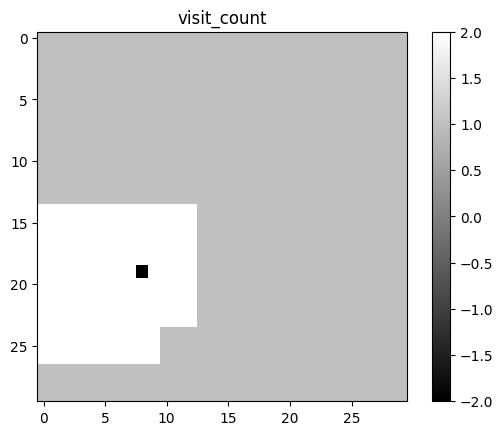

1/1 [==============================] - 0s 102ms/step
Ready to take optimal action:2 with q_values:[[ -8.751141  -10.762853   -7.8785076  -8.763107 ]]
Car moves Left 3 units from (19, 8) to (19, 5)
Cells visited: 160/900 at time step: 3

-------------------Time step: 4------------------------
Ready to take random action:1
Car moves Down 3 units from (19, 5) to (22, 5)
Cells visited: 160/900 at time step: 4

-------------------Time step: 5------------------------


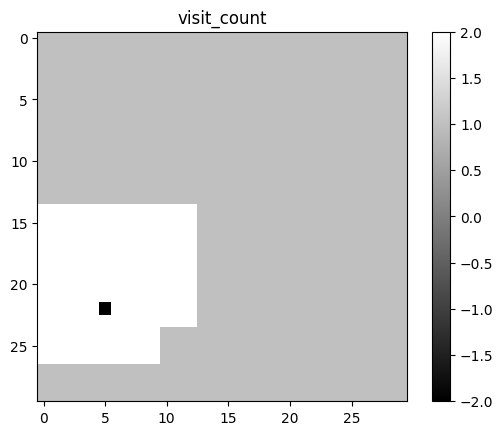

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[ -8.751141  -10.762853   -7.8785076  -8.763107 ]]
Car moves Left 3 units from (22, 5) to (22, 2)
Cells visited: 160/900 at time step: 5

-------------------Time step: 6------------------------
Ready to take random action:3
Car moves Right 3 units from (22, 2) to (22, 5)
Cells visited: 160/900 at time step: 6

-------------------Time step: 7------------------------
Ready to take random action:1
Car moves Down 3 units from (22, 5) to (25, 5)
Cells visited: 160/900 at time step: 7

-------------------Time step: 8------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 5) to (22, 5)
Cells visited: 190/900 at time step: 8

-------------------Time step: 9------------------------
Ready to take random action:2
Car moves Left 3 units from (22, 5) to (22, 2)
Cells visited: 190/900 at time step: 9

-------------------Time step: 10------------------------
Ready to take ra

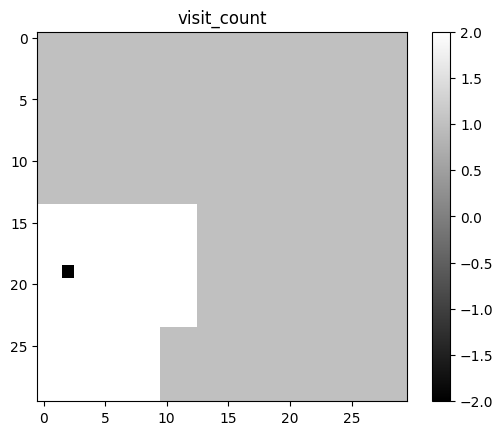

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[ -8.751141  -10.762853   -7.8785076  -8.763107 ]]
Collision! Car stays in the same position:  (19, 2)
Cells visited: 190/900 at time step: 23

-------------------Time step: 24------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 2) to (16, 2)
Cells visited: 190/900 at time step: 24

-------------------Time step: 25------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (16, 2)
Cells visited: 211/900 at time step: 25

-------------------Time step: 26------------------------


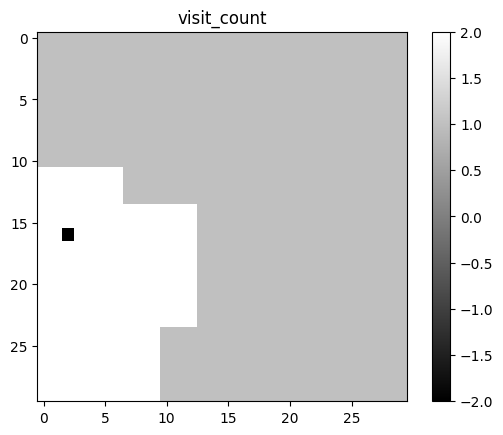

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[ -8.751141  -10.762853   -7.8785076  -8.763107 ]]
Collision! Car stays in the same position:  (16, 2)
Cells visited: 211/900 at time step: 26

-------------------Time step: 27------------------------
Ready to take random action:1
Car moves Down 3 units from (16, 2) to (19, 2)
Cells visited: 211/900 at time step: 27

-------------------Time step: 28------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 2) to (16, 2)
Cells visited: 211/900 at time step: 28

-------------------Time step: 29------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 2) to (13, 2)
Cells visited: 211/900 at time step: 29

-------------------Time step: 30------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 2)
Cells visited: 232/900 at time step: 30

-------------------Time step: 31------------------------


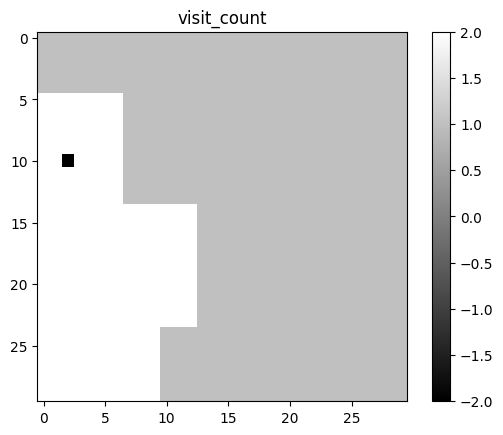

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[ -7.7950497 -10.008172   -8.485513   -9.740114 ]]
Car moves Up 3 units from (10, 2) to (7, 2)
Cells visited: 253/900 at time step: 33
Start training DQN model with batch size: 32

-------------------Time step: 34------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (7, 2)
Cells visited: 274/900 at time step: 34
Start training DQN model with batch size: 32

-------------------Time step: 35------------------------


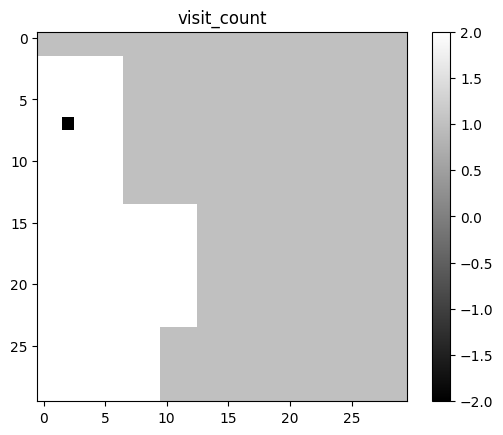

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-7.0602827 -8.859703  -9.404196  -8.274673 ]]
Car moves Up 3 units from (7, 2) to (4, 2)
Cells visited: 274/900 at time step: 35
Start training DQN model with batch size: 32

-------------------Time step: 36------------------------


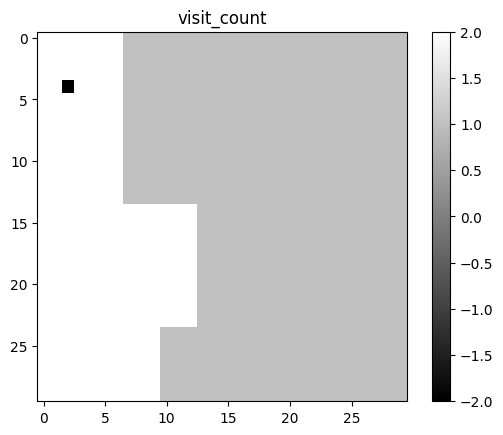

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-6.3419776 -7.912044  -9.285455  -8.270876 ]]
Car moves Up 3 units from (4, 2) to (1, 2)
Cells visited: 288/900 at time step: 36
Start training DQN model with batch size: 32

-------------------Time step: 37------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (1, 2)
Cells visited: 288/900 at time step: 37
Start training DQN model with batch size: 32

-------------------Time step: 38------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 2) to (1, 5)
Cells visited: 288/900 at time step: 38
Start training DQN model with batch size: 32

-------------------Time step: 39------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 5) to (1, 8)
Cells visited: 306/900 at time step: 39
Start training DQN model with batch size: 32

-------------------Time step: 40------------------------
Ready t

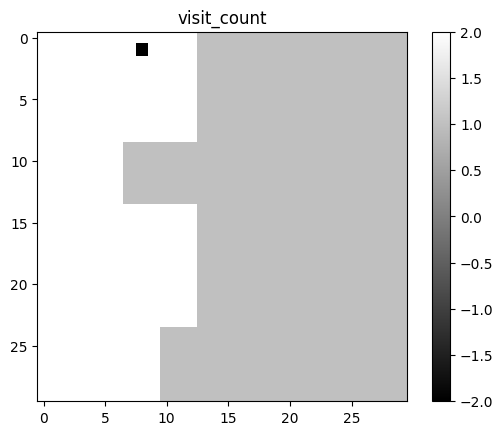

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[ 1.7811997 -2.322885  -3.683232  -3.024406 ]]
Collision! Car stays in the same position:  (1, 8)
Cells visited: 342/900 at time step: 47
Start training DQN model with batch size: 32

-------------------Time step: 48------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 8) to (1, 5)
Cells visited: 342/900 at time step: 48
Start training DQN model with batch size: 32

-------------------Time step: 49------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 5) to (1, 2)
Cells visited: 342/900 at time step: 49
Start training DQN model with batch size: 32

-------------------Time step: 50------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (1, 2)
Cells visited: 342/900 at time step: 50
Start training DQN model with batch size: 32


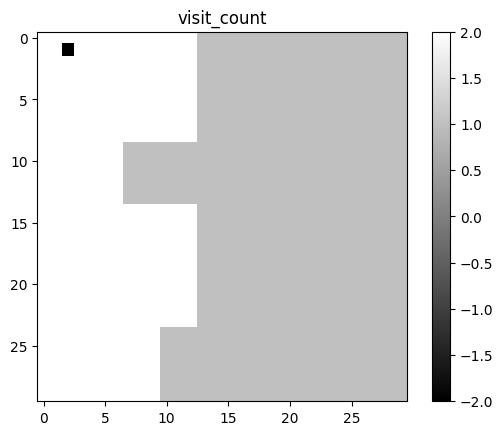


-------------------Time step: 51------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 2) to (4, 2)
Cells visited: 342/900 at time step: 51
Start training DQN model with batch size: 32

-------------------Time step: 52------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 2) to (1, 2)
Cells visited: 342/900 at time step: 52
Start training DQN model with batch size: 32

-------------------Time step: 53------------------------


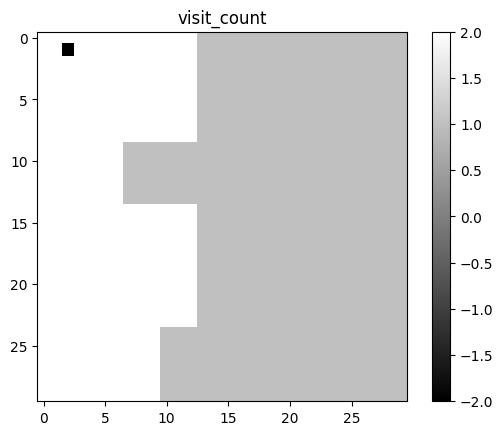

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[ 3.9539633   1.782629   -0.37723923  0.9262204 ]]
Collision! Car stays in the same position:  (1, 2)
Cells visited: 342/900 at time step: 53
Start training DQN model with batch size: 32

-------------------Time step: 54------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 2)
Cells visited: 342/900 at time step: 54
Start training DQN model with batch size: 32

-------------------Time step: 55------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 2) to (1, 5)
Cells visited: 342/900 at time step: 55
Start training DQN model with batch size: 32

-------------------Time step: 56------------------------


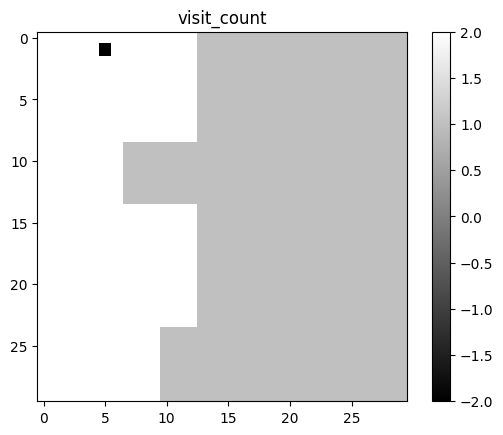

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:0 with q_values:[[4.4456334  2.6666303  0.43144345 1.8388438 ]]
Collision! Car stays in the same position:  (1, 5)
Cells visited: 342/900 at time step: 56
Start training DQN model with batch size: 32

-------------------Time step: 57------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 5) to (1, 2)
Cells visited: 342/900 at time step: 57
Start training DQN model with batch size: 32

-------------------Time step: 58------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (1, 2)
Cells visited: 342/900 at time step: 58
Start training DQN model with batch size: 32

-------------------Time step: 59------------------------


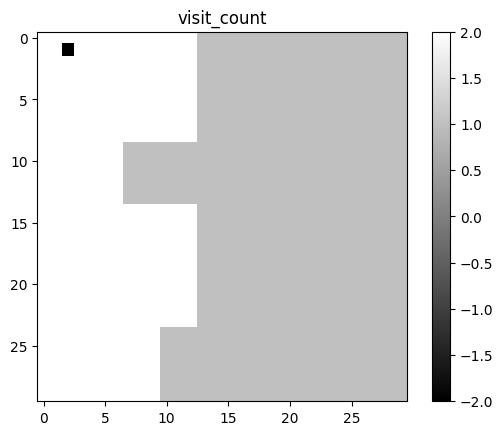

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[5.6598268 3.5634086 1.6717372 3.0974696]]
Collision! Car stays in the same position:  (1, 2)
Cells visited: 342/900 at time step: 59
Start training DQN model with batch size: 32

-------------------Time step: 60------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 2) to (1, 5)
Cells visited: 342/900 at time step: 60
Start training DQN model with batch size: 32

-------------------Time step: 61------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (1, 5)
Cells visited: 342/900 at time step: 61
Start training DQN model with batch size: 32

-------------------Time step: 62------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (1, 5)
Cells visited: 342/900 at time step: 62
Start training DQN model with batch size: 32

-------------------Time step: 63-----------------------

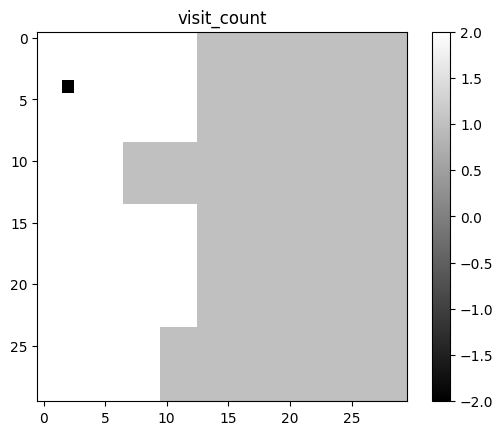

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:1 with q_values:[[2.8607302 3.8886964 1.5166221 2.7599776]]
Car moves Down 3 units from (4, 2) to (7, 2)
Cells visited: 342/900 at time step: 80
Start training DQN model with batch size: 32

-------------------Time step: 81------------------------


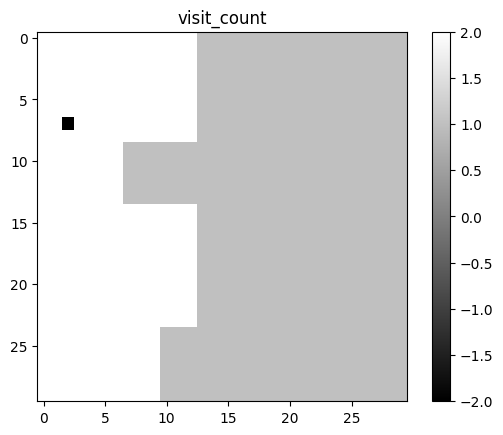

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:1 with q_values:[[2.2580514 3.1556575 1.338847  3.1117764]]
Car moves Down 3 units from (7, 2) to (10, 2)
Cells visited: 342/900 at time step: 81
Start training DQN model with batch size: 32

-------------------Time step: 82------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (10, 2)
Cells visited: 342/900 at time step: 82
Start training DQN model with batch size: 32

-------------------Time step: 83------------------------


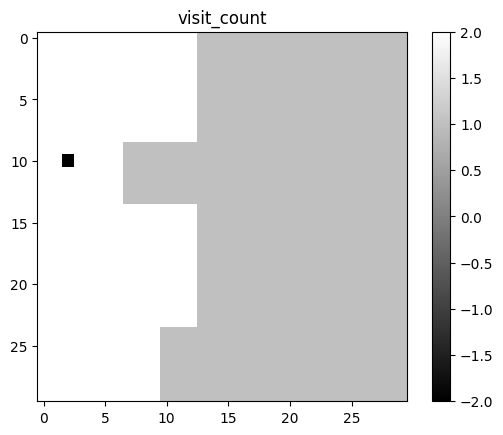

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[2.1040945 3.2210455 1.4722886 2.9298503]]
Car moves Down 3 units from (10, 2) to (13, 2)
Cells visited: 342/900 at time step: 83
Start training DQN model with batch size: 32

-------------------Time step: 84------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (13, 2)
Cells visited: 342/900 at time step: 84
Start training DQN model with batch size: 32

-------------------Time step: 85------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 2) to (16, 2)
Cells visited: 342/900 at time step: 85
Start training DQN model with batch size: 32

-------------------Time step: 86------------------------


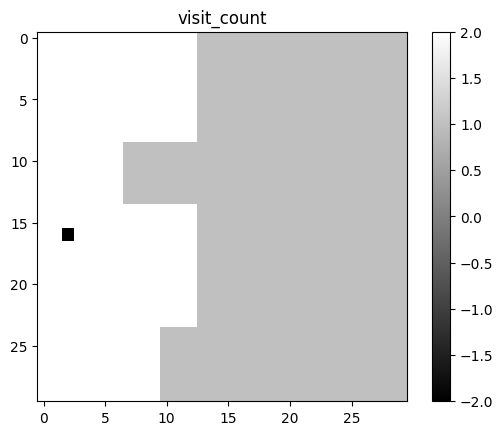

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[1.3425574 2.3267326 0.9954579 2.023116 ]]
Car moves Down 3 units from (16, 2) to (19, 2)
Cells visited: 342/900 at time step: 86
Start training DQN model with batch size: 32

-------------------Time step: 87------------------------
Ready to take random action:1
Car moves Down 3 units from (19, 2) to (22, 2)
Cells visited: 342/900 at time step: 87
Start training DQN model with batch size: 32

-------------------Time step: 88------------------------
Ready to take random action:1
Car moves Down 3 units from (22, 2) to (25, 2)
Cells visited: 342/900 at time step: 88
Start training DQN model with batch size: 32

-------------------Time step: 89------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 2) to (28, 2)
Cells visited: 342/900 at time step: 89
Start training DQN model with batch size: 32

-------------------Time step: 90------------------------
Ready to 

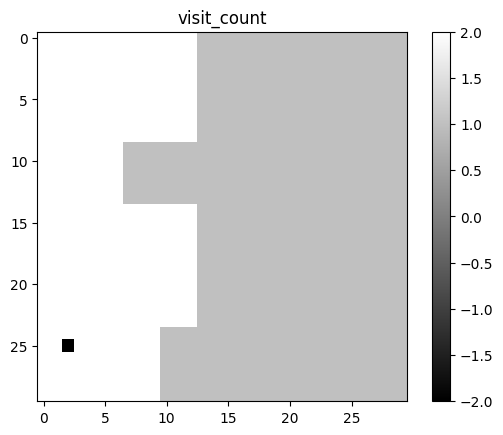

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[ 1.0547972   0.7479787  -1.5087502   0.33014515]]
Car moves Up 3 units from (25, 2) to (22, 2)
Cells visited: 342/900 at time step: 96
Start training DQN model with batch size: 32

-------------------Time step: 97------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (22, 2)
Cells visited: 342/900 at time step: 97
Start training DQN model with batch size: 32

-------------------Time step: 98------------------------
Ready to take random action:3
Car moves Right 3 units from (22, 2) to (22, 5)
Cells visited: 342/900 at time step: 98
Start training DQN model with batch size: 32

-------------------Time step: 99------------------------
Ready to take random action:2
Car moves Left 3 units from (22, 5) to (22, 2)
Cells visited: 342/900 at time step: 99
Start training DQN model with batch size: 32

-------------------Time step: 100---------------------

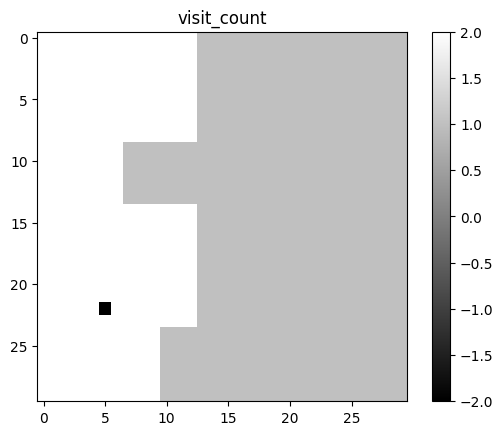


-------------------Time step: 101------------------------


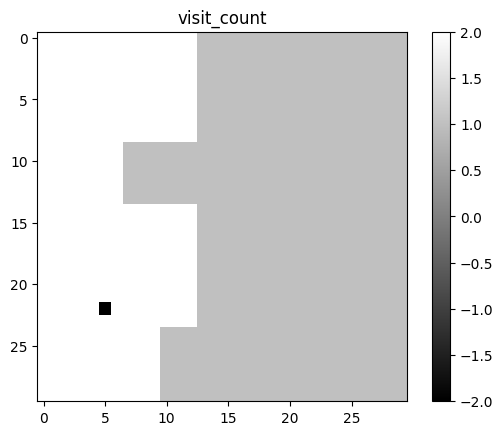

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[ 0.7051786  0.3458113 -2.216166   0.6825521]]
Car moves Up 3 units from (22, 5) to (19, 5)
Cells visited: 342/900 at time step: 101
Start training DQN model with batch size: 32

-------------------Time step: 102------------------------


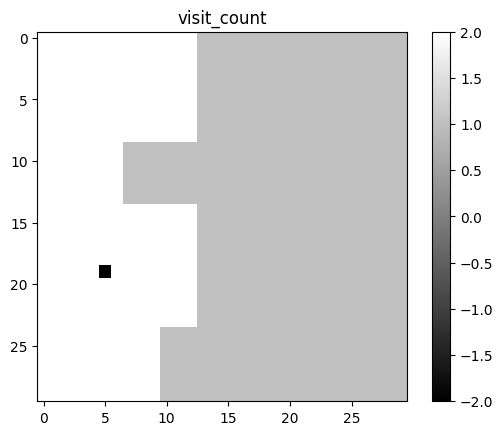

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[ 0.09531033  0.23576862 -2.6289344   0.7061646 ]]
Car moves Right 3 units from (19, 5) to (19, 8)
Cells visited: 342/900 at time step: 102
Start training DQN model with batch size: 32

-------------------Time step: 103------------------------
Ready to take random action:2
Car moves Left 3 units from (19, 8) to (19, 5)
Cells visited: 342/900 at time step: 103
Start training DQN model with batch size: 32

-------------------Time step: 104------------------------
Ready to take random action:2
Car moves Left 3 units from (19, 5) to (19, 2)
Cells visited: 342/900 at time step: 104
Start training DQN model with batch size: 32

-------------------Time step: 105------------------------


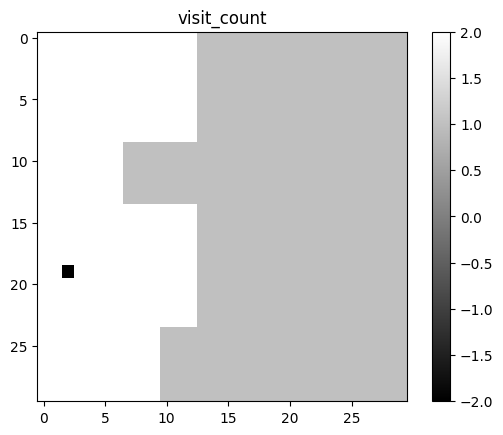

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-0.7022832   0.360543   -3.1190128   0.06237036]]
Car moves Down 3 units from (19, 2) to (22, 2)
Cells visited: 342/900 at time step: 105
Start training DQN model with batch size: 32

-------------------Time step: 106------------------------


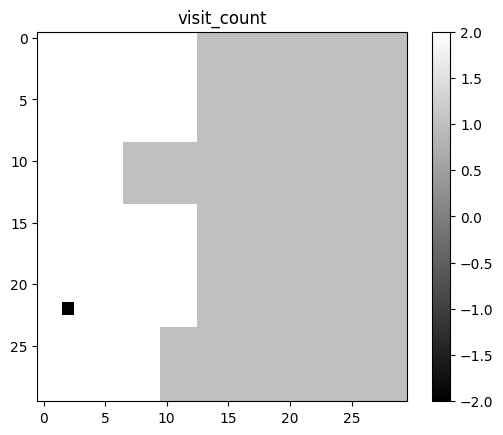

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-1.2185285   0.34238875 -2.8164222  -0.82076496]]
Car moves Down 3 units from (22, 2) to (25, 2)
Cells visited: 342/900 at time step: 106
Start training DQN model with batch size: 32

-------------------Time step: 107------------------------
Ready to take random action:3
Car moves Right 3 units from (25, 2) to (25, 5)
Cells visited: 342/900 at time step: 107
Start training DQN model with batch size: 32

-------------------Time step: 108------------------------


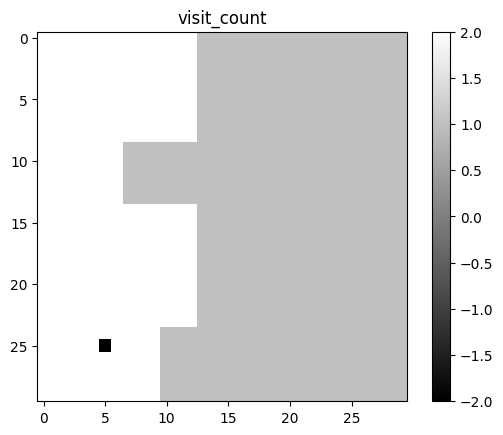

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-0.9097157 -0.5048589 -2.7271762 -1.2651956]]
Car moves Down 3 units from (25, 5) to (28, 5)
Cells visited: 342/900 at time step: 108
Start training DQN model with batch size: 32

-------------------Time step: 109------------------------


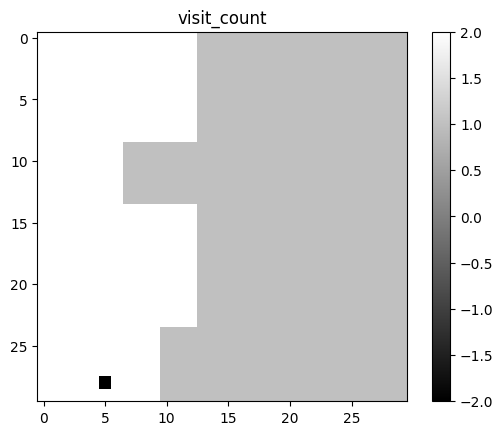

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-2.2151651  -0.43497026 -2.7376173  -1.2783353 ]]
Collision! Car stays in the same position:  (28, 5)
Cells visited: 342/900 at time step: 109
Start training DQN model with batch size: 32

-------------------Time step: 110------------------------


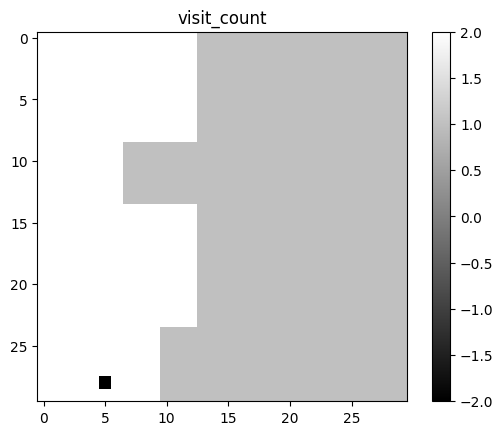

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-2.0394006 -1.4030299 -2.718684  -1.9078333]]
Collision! Car stays in the same position:  (28, 5)
Cells visited: 342/900 at time step: 110
Start training DQN model with batch size: 32

-------------------Time step: 111------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 5) to (28, 8)
Cells visited: 342/900 at time step: 111
Start training DQN model with batch size: 32

-------------------Time step: 112------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 8) to (28, 11)
Cells visited: 360/900 at time step: 112
Start training DQN model with batch size: 32

-------------------Time step: 113------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 11) to (28, 8)
Cells visited: 381/900 at time step: 113
Start training DQN model with batch size: 32

-------------------Time step: 114-------------

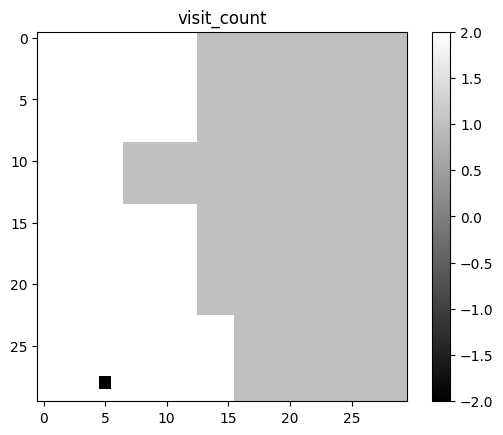

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-3.20386   -2.8547115 -3.9922173 -1.5074337]]
Car moves Right 3 units from (28, 5) to (28, 8)
Cells visited: 381/900 at time step: 116
Start training DQN model with batch size: 32

-------------------Time step: 117------------------------


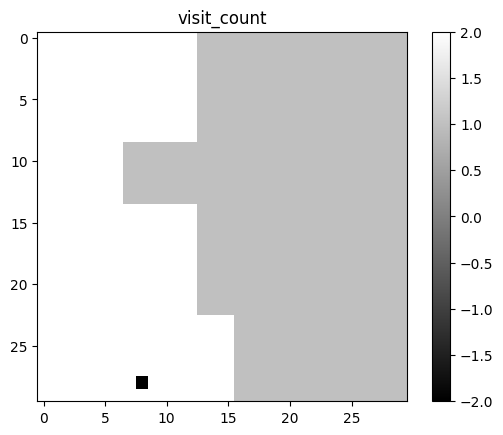

1/1 [==============================] - 0s 17ms/step
Ready to take optimal action:1 with q_values:[[-3.2893426 -2.8030071 -4.063948  -2.8867583]]
Collision! Car stays in the same position:  (28, 8)
Cells visited: 381/900 at time step: 117
Start training DQN model with batch size: 32

-------------------Time step: 118------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 8) to (28, 11)
Cells visited: 381/900 at time step: 118
Start training DQN model with batch size: 32

-------------------Time step: 119------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 11)
Cells visited: 381/900 at time step: 119
Start training DQN model with batch size: 32

-------------------Time step: 120------------------------


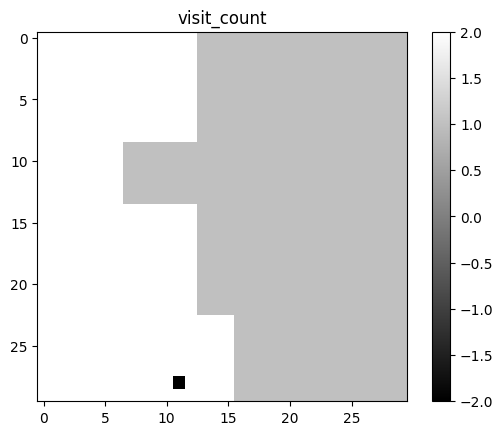

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-5.112729  -2.9739141 -4.5827165 -2.4110963]]
Car moves Right 3 units from (28, 11) to (28, 14)
Cells visited: 381/900 at time step: 120
Start training DQN model with batch size: 32

-------------------Time step: 121------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 14)
Cells visited: 402/900 at time step: 121
Start training DQN model with batch size: 32

-------------------Time step: 122------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 14)
Cells visited: 402/900 at time step: 122
Start training DQN model with batch size: 32

-------------------Time step: 123------------------------


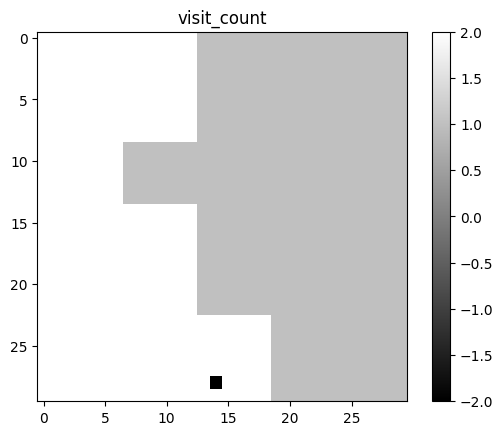

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-3.0169752 -2.7884371 -4.057536  -1.7096183]]
Car moves Right 3 units from (28, 14) to (28, 17)
Cells visited: 402/900 at time step: 123
Start training DQN model with batch size: 32

-------------------Time step: 124------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 17) to (28, 14)
Cells visited: 423/900 at time step: 124
Start training DQN model with batch size: 32

-------------------Time step: 125------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 14) to (28, 17)
Cells visited: 423/900 at time step: 125
Start training DQN model with batch size: 32

-------------------Time step: 126------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 17) to (28, 14)
Cells visited: 423/900 at time step: 126
Start training DQN model with batch size: 32

-------------------Time step: 127------------

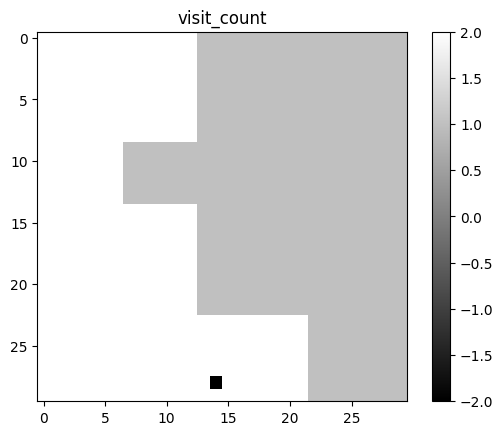

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-2.844951  -4.1256924 -5.169496  -2.7789357]]
Car moves Right 3 units from (28, 14) to (28, 17)
Cells visited: 423/900 at time step: 127
Start training DQN model with batch size: 32

-------------------Time step: 128------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 17)
Cells visited: 423/900 at time step: 128
Start training DQN model with batch size: 32

-------------------Time step: 129------------------------


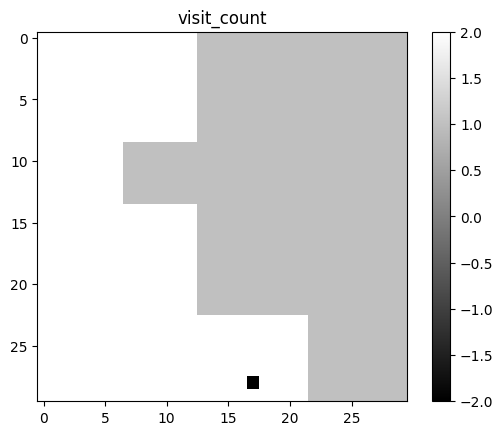

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-4.0636907 -3.555158  -5.5401554 -2.8751302]]
Car moves Right 3 units from (28, 17) to (28, 20)
Cells visited: 423/900 at time step: 129
Start training DQN model with batch size: 32

-------------------Time step: 130------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 20)
Cells visited: 444/900 at time step: 130
Start training DQN model with batch size: 32

-------------------Time step: 131------------------------


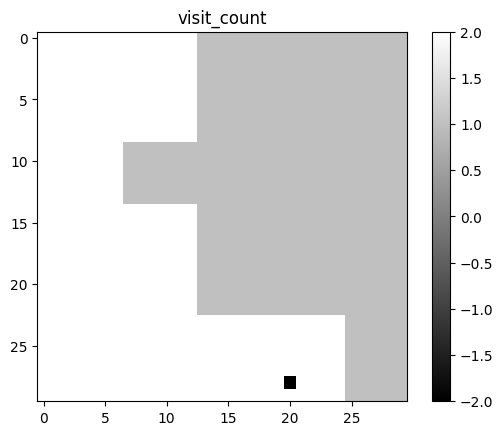

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-4.3480144 -4.065132  -6.367677  -3.3771071]]
Car moves Right 3 units from (28, 20) to (28, 23)
Cells visited: 444/900 at time step: 131
Start training DQN model with batch size: 32

-------------------Time step: 132------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 23)
Cells visited: 465/900 at time step: 132
Start training DQN model with batch size: 32

-------------------Time step: 133------------------------


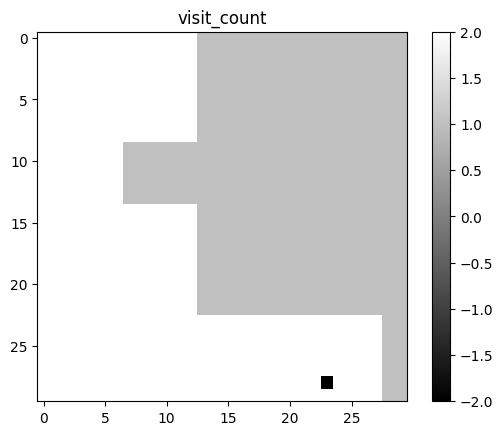

1/1 [==============================] - 0s 16ms/step
Ready to take optimal action:3 with q_values:[[-4.583881  -4.023938  -6.0278664 -3.39784  ]]
Car moves Right 3 units from (28, 23) to (28, 26)
Cells visited: 465/900 at time step: 133
Start training DQN model with batch size: 32

-------------------Time step: 134------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 26) to (25, 26)
Cells visited: 479/900 at time step: 134
Start training DQN model with batch size: 32

-------------------Time step: 135------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 26) to (25, 23)
Cells visited: 506/900 at time step: 135
Start training DQN model with batch size: 32

-------------------Time step: 136------------------------


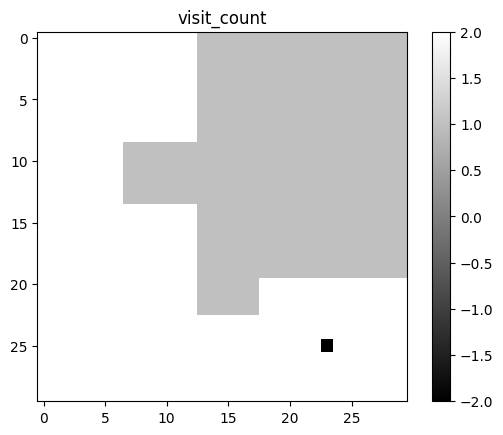

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-3.5358663 -3.8847644 -5.720564  -3.2015743]]
Car moves Right 3 units from (25, 23) to (25, 26)
Cells visited: 515/900 at time step: 136
Start training DQN model with batch size: 32

-------------------Time step: 137------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 26) to (28, 26)
Cells visited: 515/900 at time step: 137
Start training DQN model with batch size: 32

-------------------Time step: 138------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 26)
Cells visited: 515/900 at time step: 138
Start training DQN model with batch size: 32

-------------------Time step: 139------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 26) to (28, 29)
Cells visited: 515/900 at time step: 139
Start training DQN model with batch size: 32

-------------------Time step: 140--------

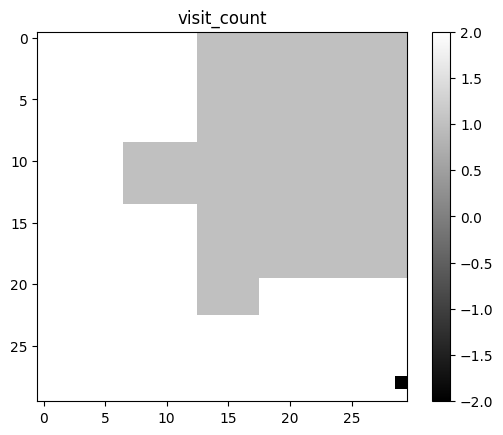


-------------------Time step: 151------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 29) to (25, 29)
Cells visited: 515/900 at time step: 151
Start training DQN model with batch size: 32

-------------------Time step: 152------------------------


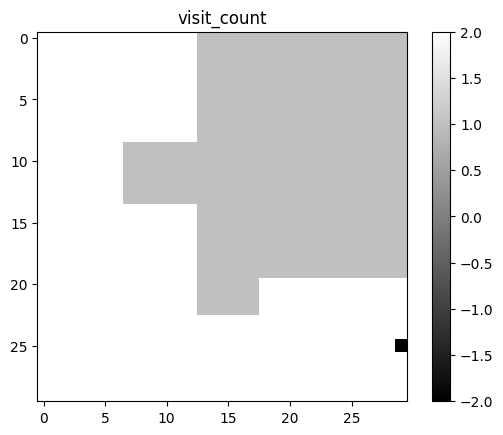

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-4.8324475 -5.037696  -6.0225344 -4.329318 ]]
Collision! Car stays in the same position:  (25, 29)
Cells visited: 515/900 at time step: 152
Start training DQN model with batch size: 32

-------------------Time step: 153------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 29) to (22, 29)
Cells visited: 515/900 at time step: 153
Start training DQN model with batch size: 32

-------------------Time step: 154------------------------
Ready to take random action:0
Car moves Up 3 units from (22, 29) to (19, 29)
Cells visited: 533/900 at time step: 154
Start training DQN model with batch size: 32

-------------------Time step: 155------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 29) to (16, 29)
Cells visited: 551/900 at time step: 155
Start training DQN model with batch size: 32

-------------------Time step: 156----------------

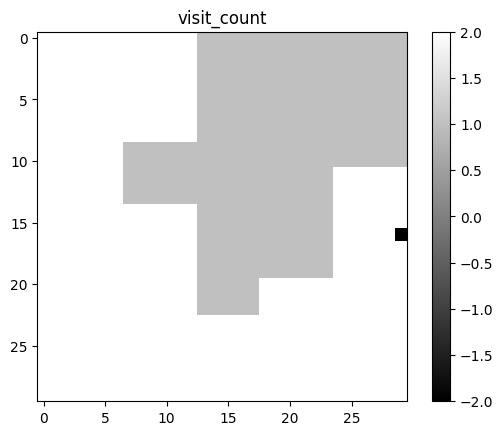

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-4.824427  -5.6979036 -4.9389377 -3.4247074]]
Collision! Car stays in the same position:  (16, 29)
Cells visited: 569/900 at time step: 156
Start training DQN model with batch size: 32

-------------------Time step: 157------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 29) to (13, 29)
Cells visited: 569/900 at time step: 157
Start training DQN model with batch size: 32

-------------------Time step: 158------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 29) to (10, 29)
Cells visited: 587/900 at time step: 158
Start training DQN model with batch size: 32

-------------------Time step: 159------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 29) to (13, 29)
Cells visited: 605/900 at time step: 159
Start training DQN model with batch size: 32

-------------------Time step: 160--------------

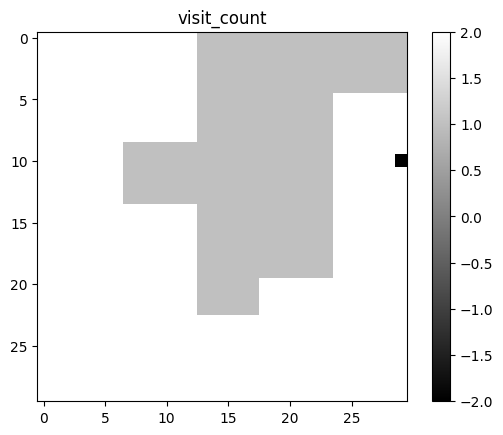

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:0 with q_values:[[-4.2554154 -4.830942  -4.946286  -4.3419976]]
Car moves Up 3 units from (10, 29) to (7, 29)
Cells visited: 605/900 at time step: 162
Start training DQN model with batch size: 32

-------------------Time step: 163------------------------
Ready to take random action:2
Car moves Left 3 units from (7, 29) to (7, 26)
Cells visited: 623/900 at time step: 163
Start training DQN model with batch size: 32

-------------------Time step: 164------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (7, 26)
Cells visited: 653/900 at time step: 164
Start training DQN model with batch size: 32

-------------------Time step: 165------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (7, 26)
Cells visited: 653/900 at time step: 165
Start training DQN model with batch size: 32

-------------------Time step: 166-------------

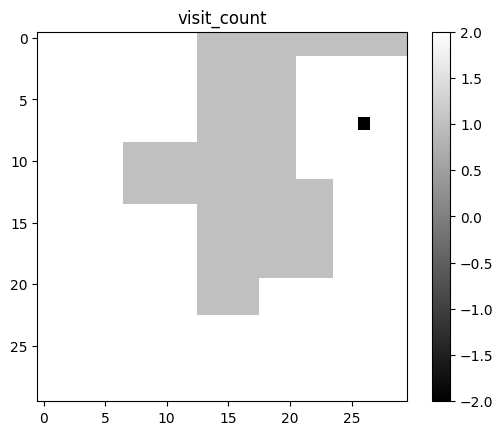

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-3.8541641 -5.6556306 -5.249818  -4.9304805]]
Car moves Up 3 units from (7, 26) to (4, 26)
Cells visited: 653/900 at time step: 166
Start training DQN model with batch size: 32

-------------------Time step: 167------------------------


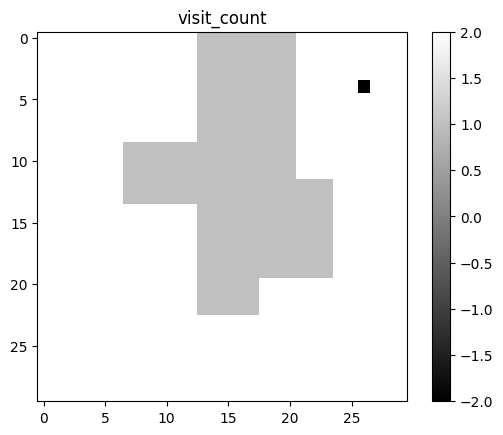

1/1 [==============================] - 0s 17ms/step
Ready to take optimal action:0 with q_values:[[-4.247368  -5.7875295 -5.368593  -5.033504 ]]
Car moves Up 3 units from (4, 26) to (1, 26)
Cells visited: 671/900 at time step: 167
Start training DQN model with batch size: 32

-------------------Time step: 168------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 671/900 at time step: 168
Start training DQN model with batch size: 32

-------------------Time step: 169------------------------


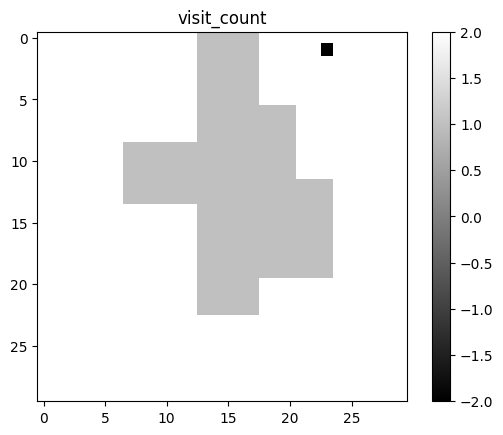

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-4.3092995 -5.998742  -5.206121  -4.455263 ]]
Collision! Car stays in the same position:  (1, 23)
Cells visited: 689/900 at time step: 169
Start training DQN model with batch size: 32

-------------------Time step: 170------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 23)
Cells visited: 689/900 at time step: 170
Start training DQN model with batch size: 32

-------------------Time step: 171------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 689/900 at time step: 171
Start training DQN model with batch size: 32

-------------------Time step: 172------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 20) to (4, 20)
Cells visited: 707/900 at time step: 172
Start training DQN model with batch size: 32

-------------------Time step: 173------------

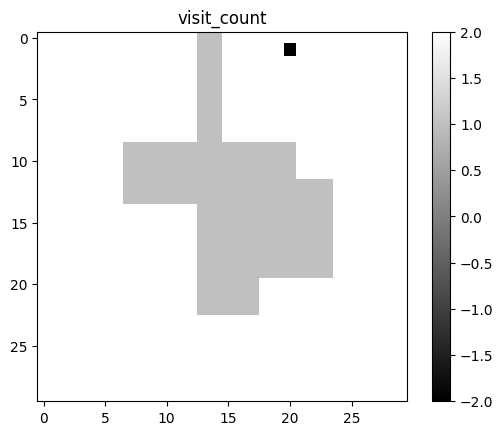

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-3.6029465 -5.6314306 -6.252513  -3.8294065]]
Collision! Car stays in the same position:  (1, 20)
Cells visited: 725/900 at time step: 177
Start training DQN model with batch size: 32

-------------------Time step: 178------------------------


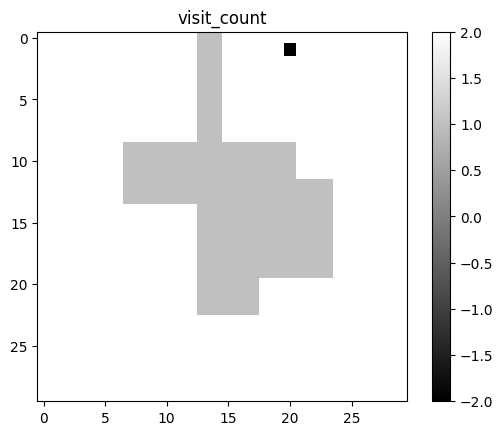

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-3.689013  -5.9826746 -6.481295  -3.2010322]]
Car moves Right 3 units from (1, 20) to (1, 23)
Cells visited: 725/900 at time step: 178
Start training DQN model with batch size: 32

-------------------Time step: 179------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 23) to (4, 23)
Cells visited: 725/900 at time step: 179
Start training DQN model with batch size: 32

-------------------Time step: 180------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 23) to (1, 23)
Cells visited: 725/900 at time step: 180
Start training DQN model with batch size: 32

-------------------Time step: 181------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 23)
Cells visited: 725/900 at time step: 181
Start training DQN model with batch size: 32

-------------------Time step: 182------------------

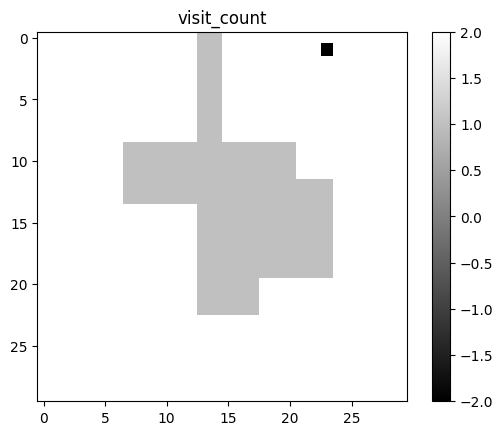

1/1 [==============================] - 0s 19ms/step
Ready to take optimal action:3 with q_values:[[-4.259093 -5.860326 -4.626349 -3.080484]]
Car moves Right 3 units from (1, 23) to (1, 26)
Cells visited: 725/900 at time step: 182
Start training DQN model with batch size: 32

-------------------Time step: 183------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 725/900 at time step: 183
Start training DQN model with batch size: 32

-------------------Time step: 184------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 725/900 at time step: 184
Start training DQN model with batch size: 32

-------------------Time step: 185------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 725/900 at time step: 185
Start training DQN model with batch size: 32

-------------------Time step: 186--------------------

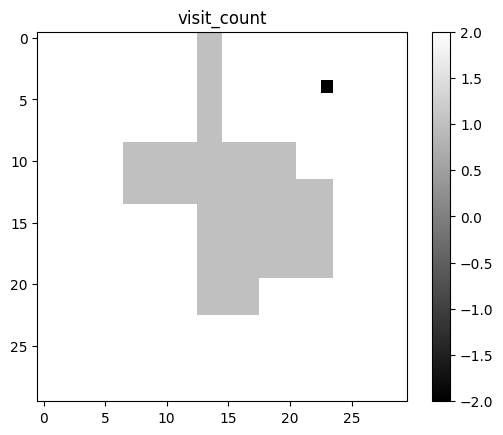

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-5.3938475 -6.469974  -7.390633  -6.411027 ]]
Car moves Up 3 units from (4, 23) to (1, 23)
Cells visited: 725/900 at time step: 193
Start training DQN model with batch size: 32

-------------------Time step: 194------------------------


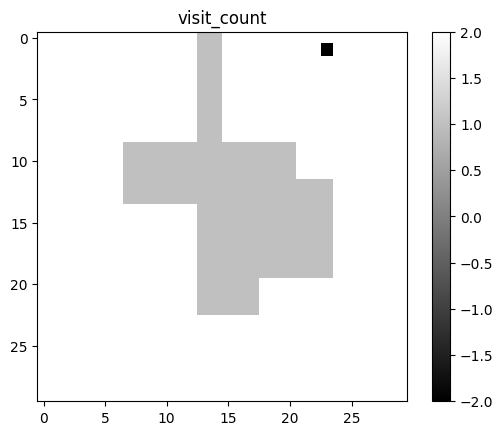

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:1 with q_values:[[-6.5229316 -6.3336415 -6.875732  -7.1348534]]
Car moves Down 3 units from (1, 23) to (4, 23)
Cells visited: 725/900 at time step: 194
Start training DQN model with batch size: 32

-------------------Time step: 195------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 23) to (4, 26)
Cells visited: 725/900 at time step: 195
Start training DQN model with batch size: 32

-------------------Time step: 196------------------------


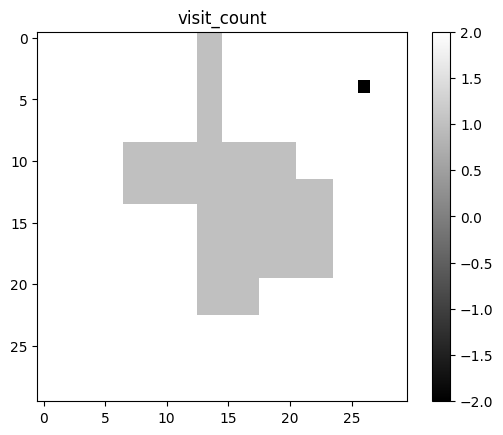

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-7.4025784 -7.269825  -6.844248  -6.436768 ]]
Car moves Right 3 units from (4, 26) to (4, 29)
Cells visited: 725/900 at time step: 196
Start training DQN model with batch size: 32

-------------------Time step: 197------------------------
Ready to take random action:2
Car moves Left 3 units from (4, 29) to (4, 26)
Cells visited: 725/900 at time step: 197
Start training DQN model with batch size: 32

-------------------Time step: 198------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 26) to (1, 26)
Cells visited: 725/900 at time step: 198
Start training DQN model with batch size: 32

-------------------Time step: 199------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 725/900 at time step: 199
Start training DQN model with batch size: 32

-------------------Time step: 200------------------

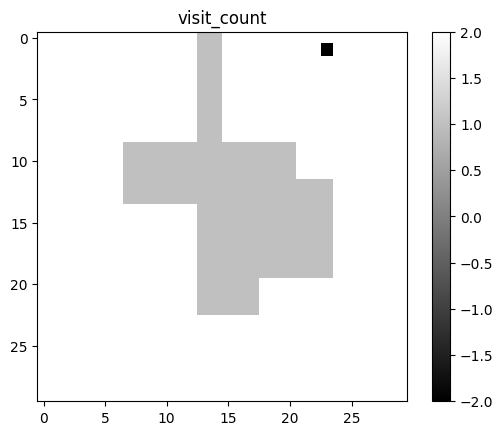


-------------------Time step: 201------------------------


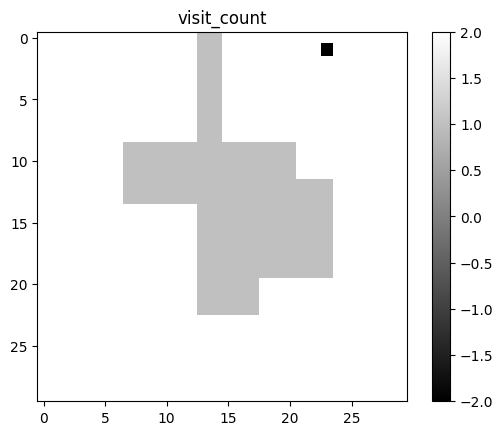

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-6.73306   -7.7464066 -7.4555006 -6.9117246]]
Collision! Car stays in the same position:  (1, 23)
Cells visited: 725/900 at time step: 201
Start training DQN model with batch size: 32

-------------------Time step: 202------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 23)
Cells visited: 725/900 at time step: 202
Start training DQN model with batch size: 32

-------------------Time step: 203------------------------


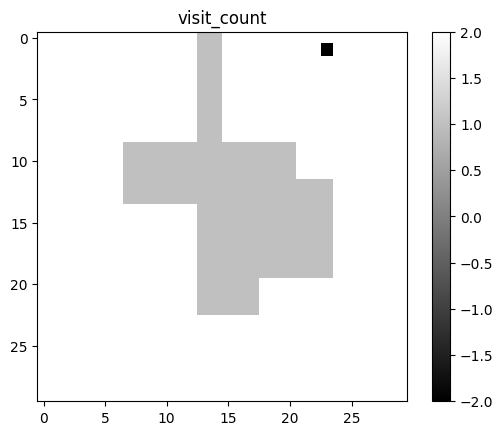

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-7.074929 -8.317041 -7.602468 -6.396597]]
Car moves Right 3 units from (1, 23) to (1, 26)
Cells visited: 725/900 at time step: 203
Start training DQN model with batch size: 32

-------------------Time step: 204------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 26) to (4, 26)
Cells visited: 725/900 at time step: 204
Start training DQN model with batch size: 32

-------------------Time step: 205------------------------
Ready to take random action:1
Car moves Down 3 units from (4, 26) to (7, 26)
Cells visited: 725/900 at time step: 205
Start training DQN model with batch size: 32

-------------------Time step: 206------------------------
Ready to take random action:0
Car moves Up 3 units from (7, 26) to (4, 26)
Cells visited: 725/900 at time step: 206
Start training DQN model with batch size: 32

-------------------Time step: 207------------------------
Re

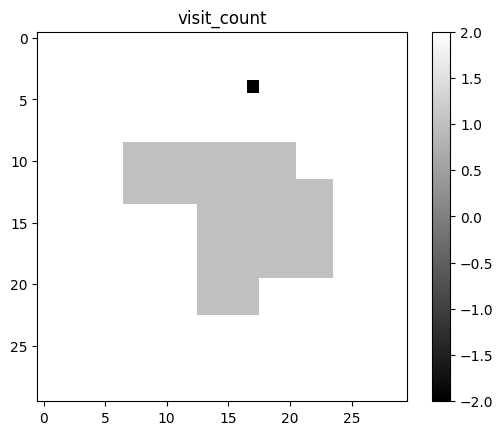

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-8.122616  -9.48456   -8.709933  -7.2051144]]
Car moves Right 3 units from (4, 17) to (4, 20)
Cells visited: 743/900 at time step: 216
Start training DQN model with batch size: 32

-------------------Time step: 217------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 20) to (1, 20)
Cells visited: 743/900 at time step: 217
Start training DQN model with batch size: 32

-------------------Time step: 218------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 20) to (4, 20)
Cells visited: 743/900 at time step: 218
Start training DQN model with batch size: 32

-------------------Time step: 219------------------------
Ready to take random action:2
Car moves Left 3 units from (4, 20) to (4, 17)
Cells visited: 743/900 at time step: 219
Start training DQN model with batch size: 32

-------------------Time step: 220-----------------------

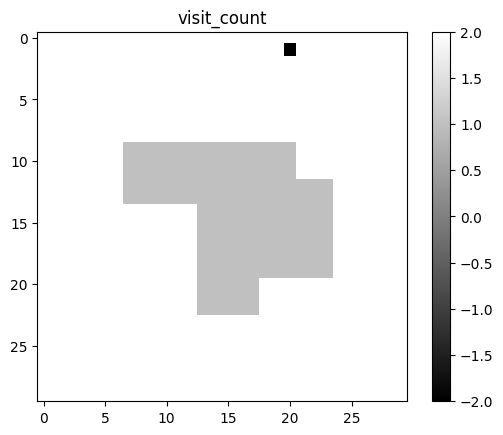

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:3 with q_values:[[-8.789985  -9.519953  -7.865391  -7.2337575]]
Car moves Right 3 units from (1, 20) to (1, 23)
Cells visited: 743/900 at time step: 222
Start training DQN model with batch size: 32

-------------------Time step: 223------------------------


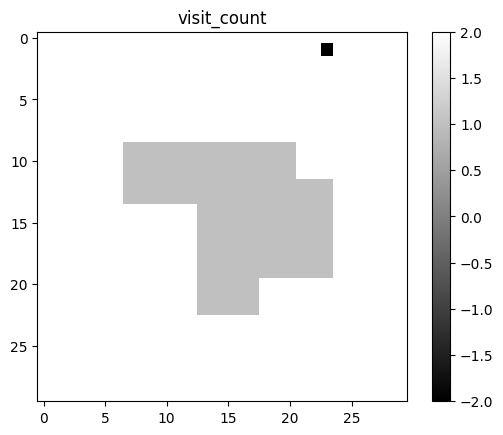

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[ -8.607562  -10.541822   -7.762072   -7.2307816]]
Car moves Right 3 units from (1, 23) to (1, 26)
Cells visited: 743/900 at time step: 223
Start training DQN model with batch size: 32

-------------------Time step: 224------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 26) to (1, 29)
Cells visited: 743/900 at time step: 224
Start training DQN model with batch size: 32

-------------------Time step: 225------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 29)
Cells visited: 743/900 at time step: 225
Start training DQN model with batch size: 32

-------------------Time step: 226------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (1, 29)
Cells visited: 743/900 at time step: 226
Start training DQN model with batch size: 32

-------------------Time step: 227------

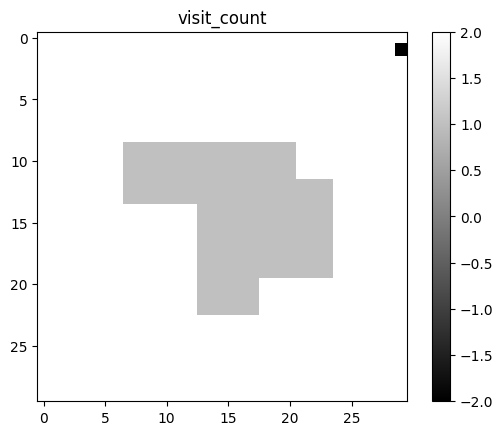

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-6.5741363 -9.310308  -7.337954  -7.184205 ]]
Collision! Car stays in the same position:  (1, 29)
Cells visited: 743/900 at time step: 227
Start training DQN model with batch size: 32

-------------------Time step: 228------------------------


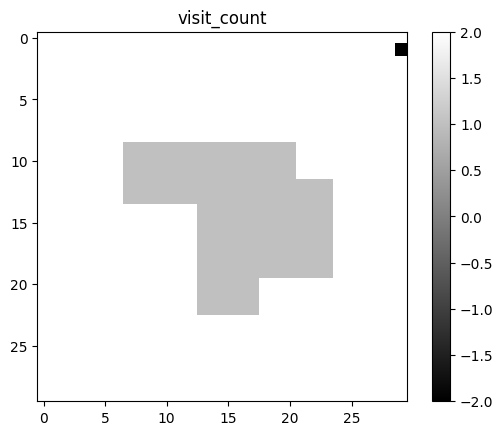

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:0 with q_values:[[-6.5792837 -7.524939  -7.2387047 -6.988616 ]]
Collision! Car stays in the same position:  (1, 29)
Cells visited: 743/900 at time step: 228
Start training DQN model with batch size: 32

-------------------Time step: 229------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 29) to (1, 26)
Cells visited: 743/900 at time step: 229
Start training DQN model with batch size: 32

-------------------Time step: 230------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 743/900 at time step: 230
Start training DQN model with batch size: 32

-------------------Time step: 231------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 743/900 at time step: 231
Start training DQN model with batch size: 32

-------------------Time step: 232-------

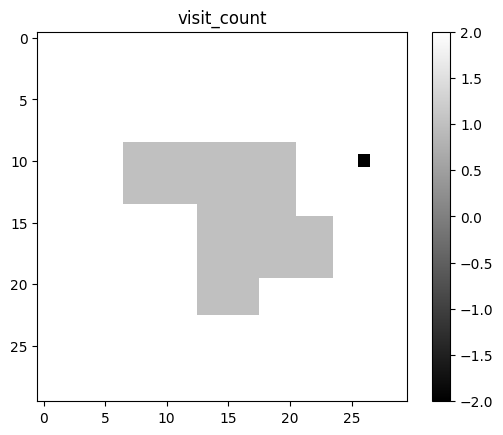

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:3 with q_values:[[-10.061495 -10.666031 -11.745216  -9.056836]]
Car moves Right 3 units from (10, 26) to (10, 29)
Cells visited: 752/900 at time step: 239
Start training DQN model with batch size: 32

-------------------Time step: 240------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 29) to (13, 29)
Cells visited: 752/900 at time step: 240
Start training DQN model with batch size: 32

-------------------Time step: 241------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 29) to (16, 29)
Cells visited: 752/900 at time step: 241
Start training DQN model with batch size: 32

-------------------Time step: 242------------------------
Ready to take random action:2
Car moves Left 3 units from (16, 29) to (16, 26)
Cells visited: 752/900 at time step: 242
Start training DQN model with batch size: 32

-------------------Time step: 243-------------

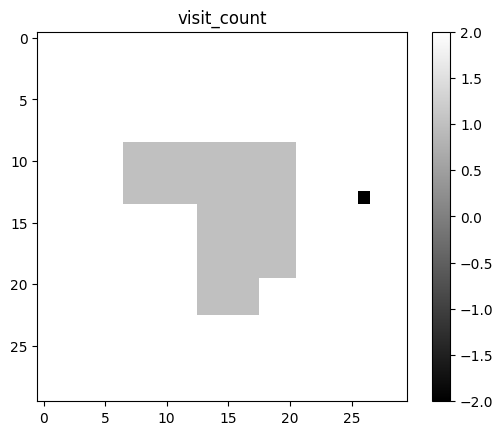

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[ -8.114012 -10.342975 -10.43311   -7.376715]]
Car moves Right 3 units from (13, 26) to (13, 29)
Cells visited: 767/900 at time step: 246
Start training DQN model with batch size: 32

-------------------Time step: 247------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 29)
Cells visited: 767/900 at time step: 247
Start training DQN model with batch size: 32

-------------------Time step: 248------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 29) to (13, 26)
Cells visited: 767/900 at time step: 248
Start training DQN model with batch size: 32

-------------------Time step: 249------------------------
Ready to take random action:3
Car moves Right 3 units from (13, 26) to (13, 29)
Cells visited: 767/900 at time step: 249
Start training DQN model with batch size: 32

-------------------Time step: 250--------

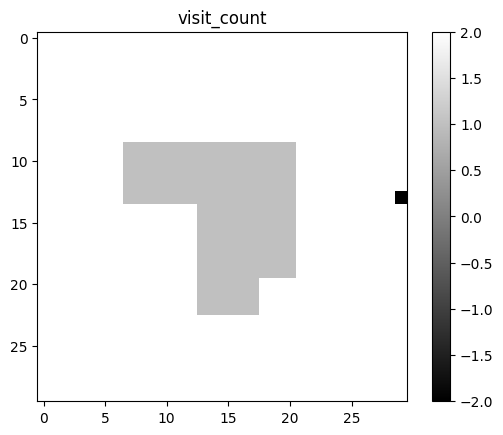

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:3 with q_values:[[-8.89364   -9.565472  -9.789122  -7.3202467]]
Collision! Car stays in the same position:  (13, 29)
Cells visited: 767/900 at time step: 250
Start training DQN model with batch size: 32


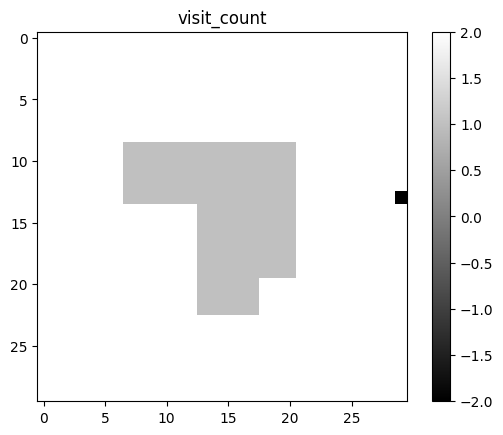


-------------------Time step: 251------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 29) to (16, 29)
Cells visited: 767/900 at time step: 251
Start training DQN model with batch size: 32

-------------------Time step: 252------------------------


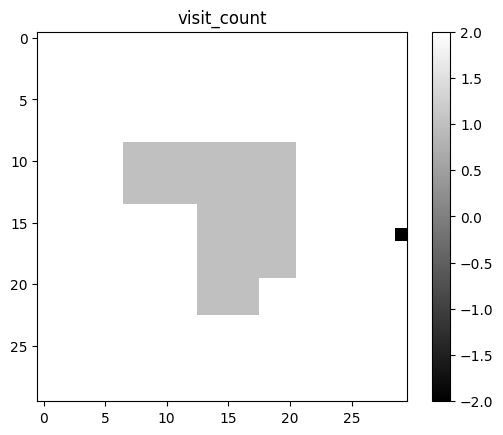

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[ -9.088197  -9.013774 -10.564906  -7.348405]]
Collision! Car stays in the same position:  (16, 29)
Cells visited: 767/900 at time step: 252
Start training DQN model with batch size: 32

-------------------Time step: 253------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (16, 29)
Cells visited: 767/900 at time step: 253
Start training DQN model with batch size: 32

-------------------Time step: 254------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (16, 29)
Cells visited: 767/900 at time step: 254
Start training DQN model with batch size: 32

-------------------Time step: 255------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (16, 29)
Cells visited: 767/900 at time step: 255
Start training DQN model with batch size: 32

-------------------Time step: 2

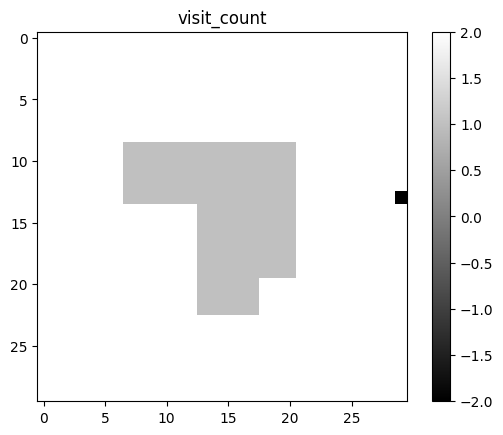

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-12.025565  -10.737564  -11.4091625 -10.685148 ]]
Collision! Car stays in the same position:  (13, 29)
Cells visited: 767/900 at time step: 266
Start training DQN model with batch size: 32

-------------------Time step: 267------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 29)
Cells visited: 767/900 at time step: 267
Start training DQN model with batch size: 32

-------------------Time step: 268------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 29) to (13, 26)
Cells visited: 767/900 at time step: 268
Start training DQN model with batch size: 32

-------------------Time step: 269------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 26) to (16, 26)
Cells visited: 767/900 at time step: 269
Start training DQN model with batch size: 32

-------------------Time step: 270--

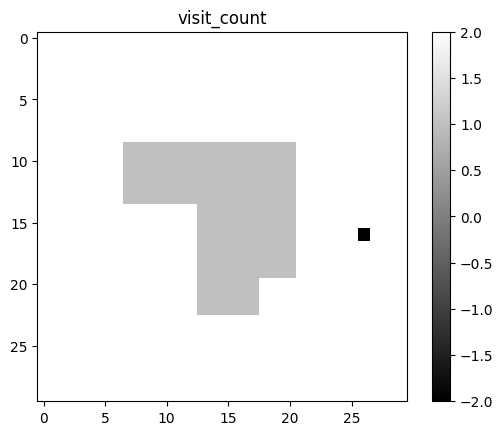

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[-11.571009 -12.03557  -10.948336 -12.362896]]
Car moves Left 3 units from (16, 26) to (16, 23)
Cells visited: 767/900 at time step: 270
Start training DQN model with batch size: 32

-------------------Time step: 271------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 23) to (13, 23)
Cells visited: 794/900 at time step: 271
Start training DQN model with batch size: 32

-------------------Time step: 272------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 23) to (13, 20)
Cells visited: 800/900 at time step: 272
Start training DQN model with batch size: 32

-------------------Time step: 273------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 20) to (10, 20)
Cells visited: 827/900 at time step: 273
Start training DQN model with batch size: 32

-------------------Time step: 274------------------

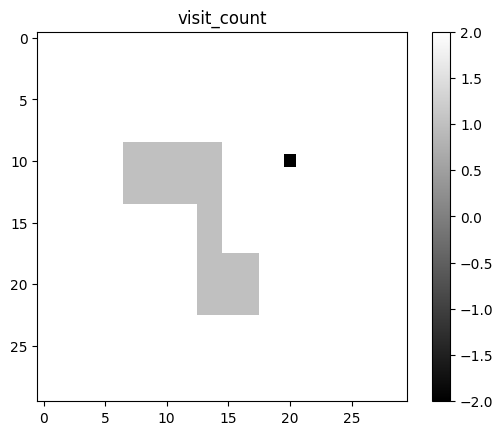

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-11.508936 -13.34508  -12.079468 -11.652401]]
Car moves Up 3 units from (10, 20) to (7, 20)
Cells visited: 827/900 at time step: 274
Start training DQN model with batch size: 32

-------------------Time step: 275------------------------
Ready to take random action:0
Car moves Up 3 units from (7, 20) to (4, 20)
Cells visited: 827/900 at time step: 275
Start training DQN model with batch size: 32

-------------------Time step: 276------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 20) to (1, 20)
Cells visited: 827/900 at time step: 276
Start training DQN model with batch size: 32

-------------------Time step: 277------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 20) to (1, 17)
Cells visited: 827/900 at time step: 277
Start training DQN model with batch size: 32

-------------------Time step: 278------------------------
Re

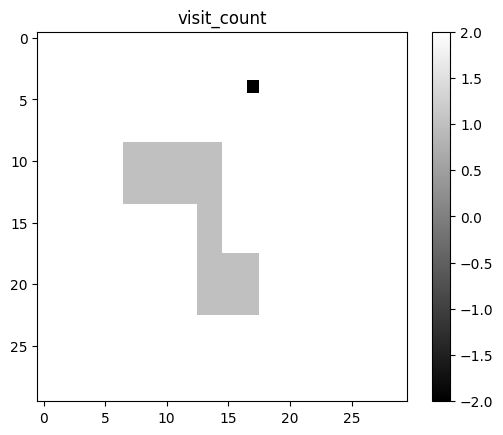

1/1 [==============================] - 0s 16ms/step
Ready to take optimal action:2 with q_values:[[-13.057768 -13.816455 -12.436593 -13.829648]]
Collision! Car stays in the same position:  (4, 17)
Cells visited: 827/900 at time step: 279
Start training DQN model with batch size: 32

-------------------Time step: 280------------------------


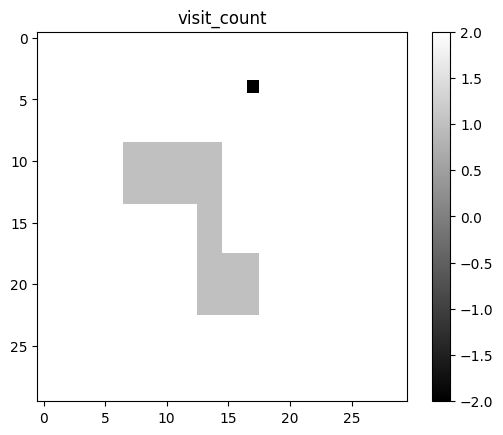

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[-13.449809 -13.876445 -12.464656 -13.438628]]
Collision! Car stays in the same position:  (4, 17)
Cells visited: 827/900 at time step: 280
Start training DQN model with batch size: 32

-------------------Time step: 281------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (4, 17)
Cells visited: 827/900 at time step: 281
Start training DQN model with batch size: 32

-------------------Time step: 282------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 17) to (4, 20)
Cells visited: 827/900 at time step: 282
Start training DQN model with batch size: 32

-------------------Time step: 283------------------------


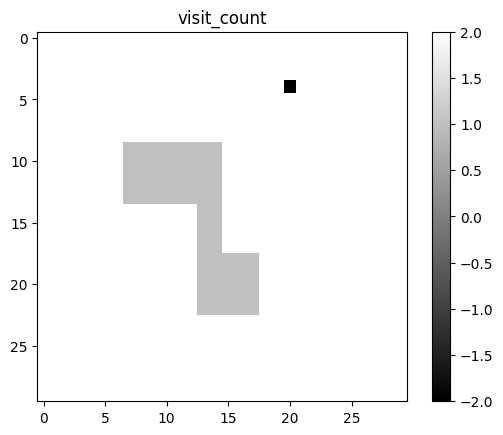

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-14.735458 -13.938884 -13.374458 -13.14425 ]]
Car moves Right 3 units from (4, 20) to (4, 23)
Cells visited: 827/900 at time step: 283
Start training DQN model with batch size: 32

-------------------Time step: 284------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 23) to (1, 23)
Cells visited: 827/900 at time step: 284
Start training DQN model with batch size: 32

-------------------Time step: 285------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 23) to (1, 26)
Cells visited: 827/900 at time step: 285
Start training DQN model with batch size: 32

-------------------Time step: 286------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 827/900 at time step: 286
Start training DQN model with batch size: 32

-------------------Time step: 287----------------------

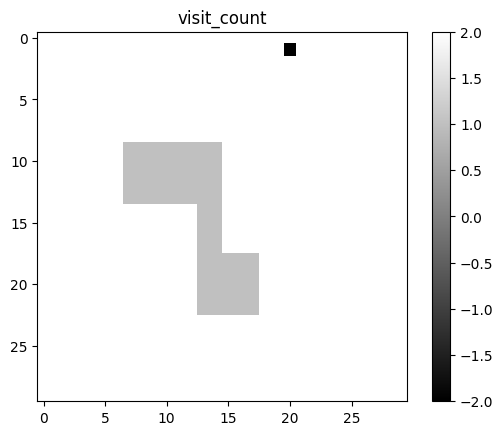

1/1 [==============================] - 0s 21ms/step
Ready to take optimal action:3 with q_values:[[-14.278007 -14.376719 -14.232175 -13.668166]]
Car moves Right 3 units from (1, 20) to (1, 23)
Cells visited: 827/900 at time step: 289
Start training DQN model with batch size: 32

-------------------Time step: 290------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 23) to (4, 23)
Cells visited: 827/900 at time step: 290
Start training DQN model with batch size: 32

-------------------Time step: 291------------------------


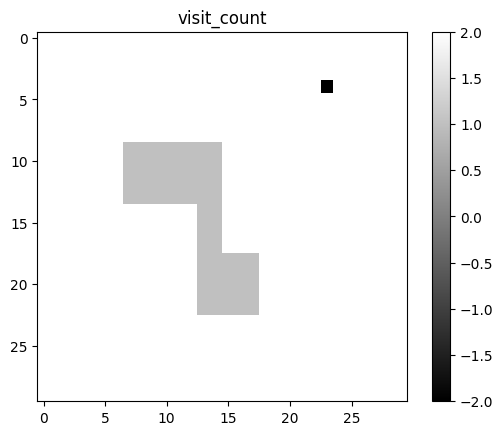

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[-14.418157 -15.351672 -14.167112 -15.362633]]
Car moves Left 3 units from (4, 23) to (4, 20)
Cells visited: 827/900 at time step: 291
Start training DQN model with batch size: 32

-------------------Time step: 292------------------------
Ready to take random action:1
Car moves Down 3 units from (4, 20) to (7, 20)
Cells visited: 827/900 at time step: 292
Start training DQN model with batch size: 32

-------------------Time step: 293------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 20) to (10, 20)
Cells visited: 827/900 at time step: 293
Start training DQN model with batch size: 32

-------------------Time step: 294------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 20) to (10, 23)
Cells visited: 827/900 at time step: 294
Start training DQN model with batch size: 32

-------------------Time step: 295------------------

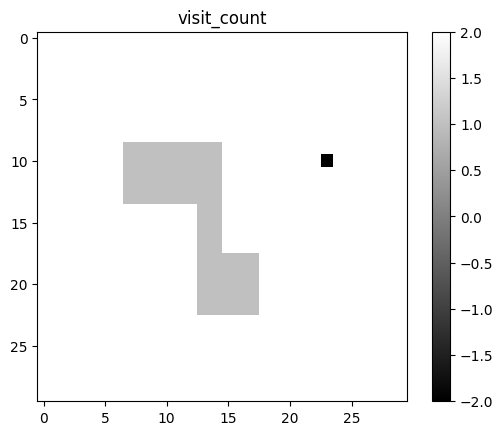

1/1 [==============================] - 0s 18ms/step
Ready to take optimal action:2 with q_values:[[-15.956276 -16.084505 -15.201757 -15.719436]]
Car moves Left 3 units from (10, 23) to (10, 20)
Cells visited: 827/900 at time step: 295
Start training DQN model with batch size: 32

-------------------Time step: 296------------------------
Ready to take random action:0
Car moves Up 3 units from (10, 20) to (7, 20)
Cells visited: 827/900 at time step: 296
Start training DQN model with batch size: 32

-------------------Time step: 297------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 20) to (10, 20)
Cells visited: 827/900 at time step: 297
Start training DQN model with batch size: 32

-------------------Time step: 298------------------------


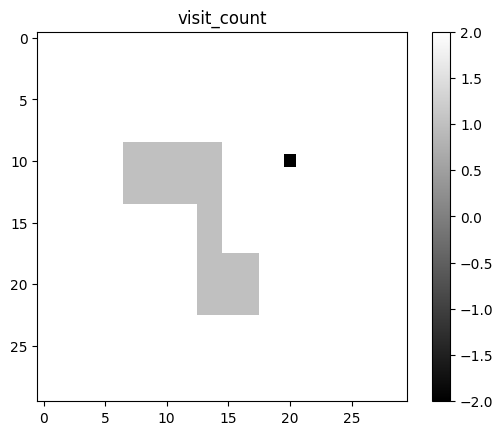

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:2 with q_values:[[-15.625087 -16.353996 -15.139054 -16.735138]]
Car moves Left 3 units from (10, 20) to (10, 17)
Cells visited: 827/900 at time step: 298
Start training DQN model with batch size: 32

-------------------Time step: 299------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 17)
Cells visited: 844/900 at time step: 299
Start training DQN model with batch size: 32

-------------------Time step: 300------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 17) to (10, 20)
Cells visited: 844/900 at time step: 300
Start training DQN model with batch size: 32


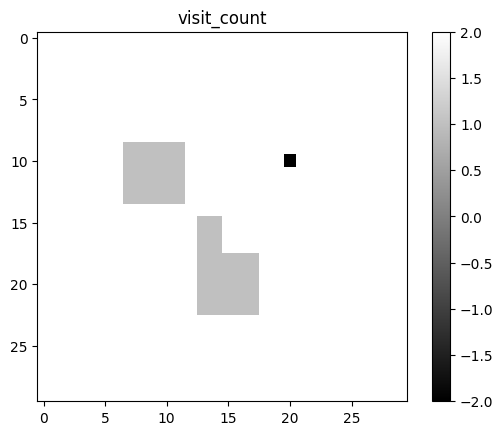


-------------------Time step: 301------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 20) to (10, 17)
Cells visited: 844/900 at time step: 301
Start training DQN model with batch size: 32

-------------------Time step: 302------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 17)
Cells visited: 844/900 at time step: 302
Start training DQN model with batch size: 32

-------------------Time step: 303------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 17) to (13, 17)
Cells visited: 844/900 at time step: 303
Start training DQN model with batch size: 32

-------------------Time step: 304------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 17) to (10, 17)
Cells visited: 850/900 at time step: 304
Start training DQN model with batch size: 32

-------------------Time step: 305------------------------


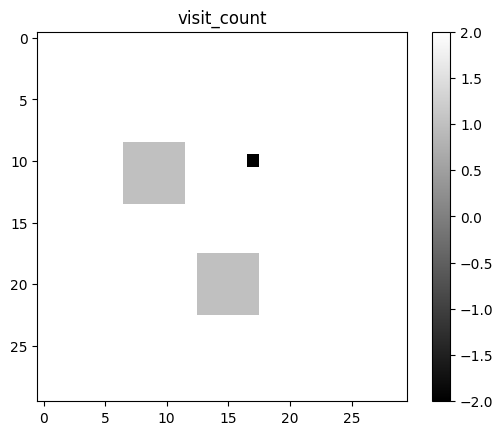

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-16.099121 -17.612123 -17.037735 -16.534662]]
Collision! Car stays in the same position:  (10, 17)
Cells visited: 850/900 at time step: 305
Start training DQN model with batch size: 32

-------------------Time step: 306------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 17) to (10, 14)
Cells visited: 850/900 at time step: 306
Start training DQN model with batch size: 32

-------------------Time step: 307------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 14) to (10, 11)
Cells visited: 865/900 at time step: 307
Start training DQN model with batch size: 32

-------------------Time step: 308------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 11) to (10, 14)
Cells visited: 875/900 at time step: 308
Start training DQN model with batch size: 32

-------------------Time step: 309---------

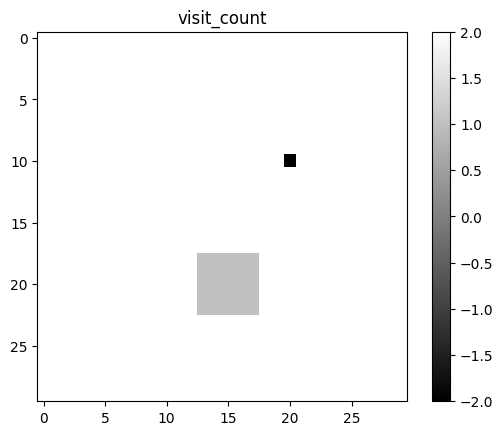

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:1 with q_values:[[-17.805079 -16.60882  -17.648205 -18.168226]]
Car moves Down 3 units from (10, 20) to (13, 20)
Cells visited: 875/900 at time step: 313
Start training DQN model with batch size: 32

-------------------Time step: 314------------------------
Ready to take random action:3
Car moves Right 3 units from (13, 20) to (13, 23)
Cells visited: 875/900 at time step: 314
Start training DQN model with batch size: 32

-------------------Time step: 315------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 23) to (13, 20)
Cells visited: 875/900 at time step: 315
Start training DQN model with batch size: 32

-------------------Time step: 316------------------------
Ready to take random action:3
Car moves Right 3 units from (13, 20) to (13, 23)
Cells visited: 875/900 at time step: 316
Start training DQN model with batch size: 32

-------------------Time step: 317------------

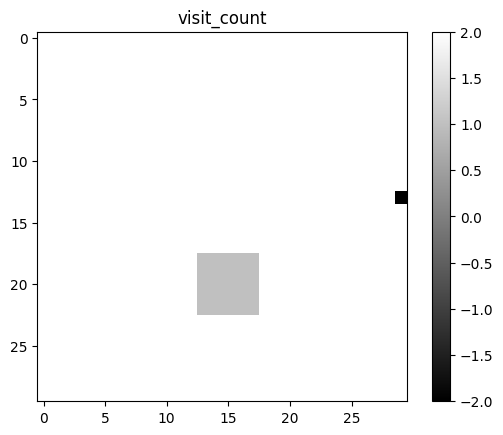

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:2 with q_values:[[-19.133724 -19.396627 -18.602264 -20.631392]]
Car moves Left 3 units from (13, 29) to (13, 26)
Cells visited: 875/900 at time step: 324
Start training DQN model with batch size: 32

-------------------Time step: 325------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 26) to (16, 26)
Cells visited: 875/900 at time step: 325
Start training DQN model with batch size: 32

-------------------Time step: 326------------------------
Ready to take random action:3
Car moves Right 3 units from (16, 26) to (16, 29)
Cells visited: 875/900 at time step: 326
Start training DQN model with batch size: 32

-------------------Time step: 327------------------------
Ready to take random action:2
Car moves Left 3 units from (16, 29) to (16, 26)
Cells visited: 875/900 at time step: 327
Start training DQN model with batch size: 32

-------------------Time step: 328-------------

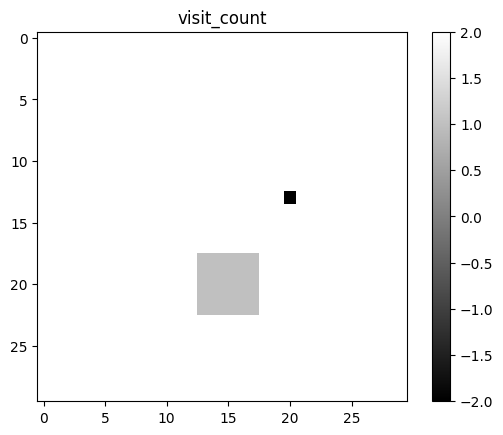

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-20.637802 -20.098314 -19.505611 -19.433699]]
Car moves Right 3 units from (13, 20) to (13, 23)
Cells visited: 875/900 at time step: 333
Start training DQN model with batch size: 32

-------------------Time step: 334------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 23) to (10, 23)
Cells visited: 875/900 at time step: 334
Start training DQN model with batch size: 32

-------------------Time step: 335------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 23)
Cells visited: 875/900 at time step: 335
Start training DQN model with batch size: 32

-------------------Time step: 336------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 23) to (13, 23)
Cells visited: 875/900 at time step: 336
Start training DQN model with batch size: 32

-------------------Time step: 337-----------

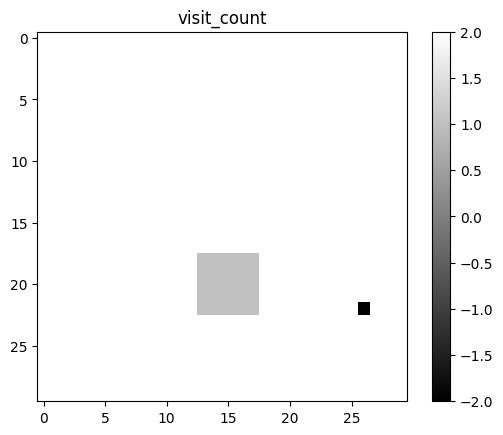

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:1 with q_values:[[-20.804255 -20.044472 -20.4218   -20.639896]]
Car moves Down 3 units from (22, 26) to (25, 26)
Cells visited: 875/900 at time step: 342
Start training DQN model with batch size: 32

-------------------Time step: 343------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 26) to (25, 23)
Cells visited: 875/900 at time step: 343
Start training DQN model with batch size: 32

-------------------Time step: 344------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 23) to (25, 20)
Cells visited: 875/900 at time step: 344
Start training DQN model with batch size: 32

-------------------Time step: 345------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 20) to (25, 17)
Cells visited: 884/900 at time step: 345
Start training DQN model with batch size: 32

-------------------Time step: 346--------------

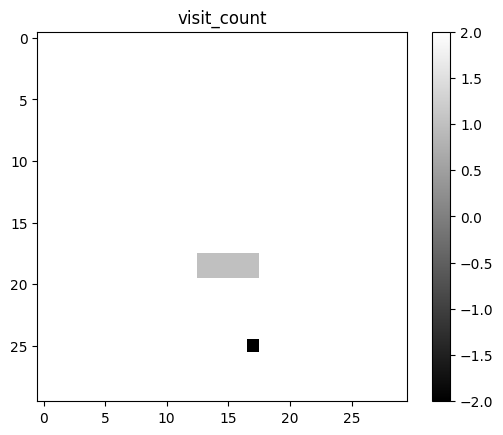

1/1 [==============================] - 0s 31ms/step
Ready to take optimal action:1 with q_values:[[-20.591003 -20.162308 -21.115244 -20.228683]]
Car moves Down 3 units from (25, 17) to (28, 17)
Cells visited: 890/900 at time step: 346
Start training DQN model with batch size: 32

-------------------Time step: 347------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 17) to (28, 20)
Cells visited: 890/900 at time step: 347
Start training DQN model with batch size: 32

-------------------Time step: 348------------------------


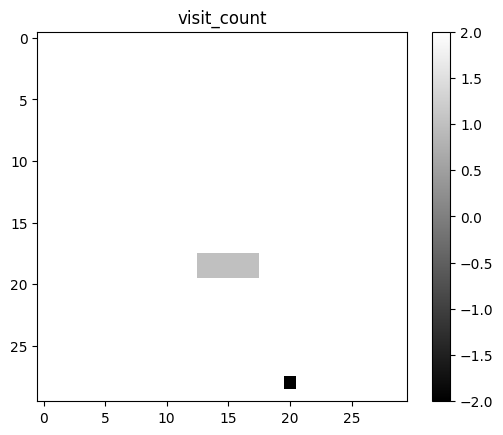

1/1 [==============================] - 0s 15ms/step
Ready to take optimal action:3 with q_values:[[-20.518309 -21.505985 -21.232824 -20.33495 ]]
Car moves Right 3 units from (28, 20) to (28, 23)
Cells visited: 890/900 at time step: 348
Start training DQN model with batch size: 32

-------------------Time step: 349------------------------


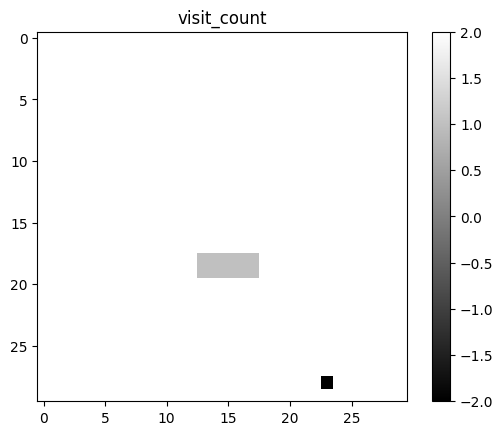

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-21.292826 -21.413637 -21.135487 -20.316732]]
Car moves Right 3 units from (28, 23) to (28, 26)
Cells visited: 890/900 at time step: 349
Start training DQN model with batch size: 32

-------------------Time step: 350------------------------


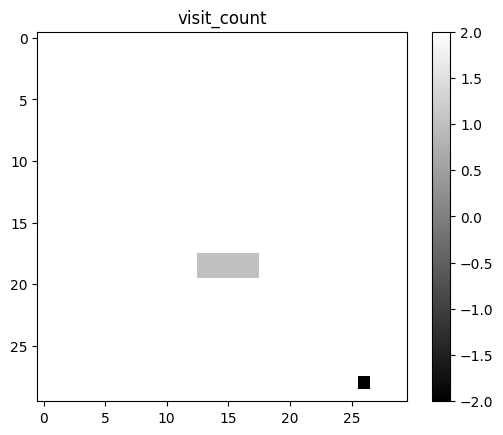

1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:3 with q_values:[[-21.266876 -21.381592 -21.120375 -20.158897]]
Car moves Right 3 units from (28, 26) to (28, 29)
Cells visited: 890/900 at time step: 350
Start training DQN model with batch size: 32


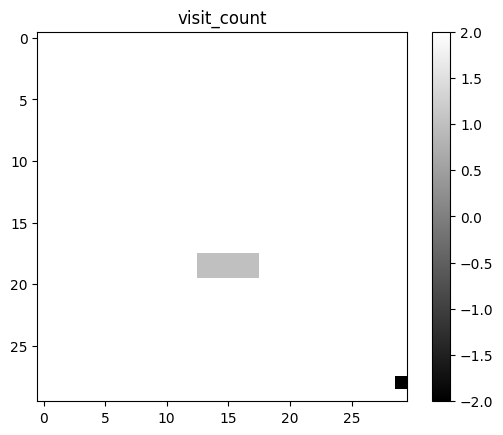


-------------------Time step: 351------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 29)
Cells visited: 890/900 at time step: 351
Start training DQN model with batch size: 32


KeyboardInterrupt: 

In [10]:
# Test the model
if train_mode == 'test':
    # Reset the environment and get the initial state
    state = env.reset()
    state,_ = prepare_state(state)
    replay_buffer = deque(maxlen=2000)
    images = []

    # Loop through each time step
    for time_step in range(time_steps): 
        print(f"\n-------------------Time step: {time_step}------------------------")
        images.append(env.visit_count / np.max(env.visit_count) * 255)
        # In each time step, agent selects an action and implement it, environment provides feedback
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        if done:
            env.render(map_type="visit_count")
            save_to_gif(images,'test_dqn_gif', f'policy_by_DQN_{time.strftime("%m-%d_%H-%M")}.gif')
            print("ALL DONE")
            break
        cells_visited = state[0][state[0] == EXPLORED].shape[0] # 计算已经访问的cell数量
        cells = env.map_size[0]*env.map_size[1]
        print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")

        # Store the data into replay buffer
        next_state,_ = prepare_state(next_state)
        replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

        # Update state
        state = next_state

        # Training while testing
        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)

            # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
            if time_step % 50 == 0:
                env.render(map_type="visit_count")
                epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
